In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [26]:
import subprocess
import sys
def install(package):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
install('ipympl')

from google.colab import output
output.enable_custom_widget_manager()


In [27]:
%matplotlib ipympl

#Homography

In [28]:

def find_homography(points_source, points_target):
    num_points = points_source.shape[0]
    A = []
    for i in range(num_points):
        x, y = points_source[i]
        x_t, y_t = points_target[i]
        A_for_one_point = [
            [-x, -y, -1, 0, 0, 0, x_t * x, x_t * y, x_t],
            [0, 0, 0, -x, -y, -1, y_t * x, y_t * y, y_t],
        ]
        A.extend(A_for_one_point)

    A = np.array(A)
    H = np.zeros((3, 3))

    U, D, Vt = np.linalg.svd(A)

    H[0, :] = Vt[-1][0:3]
    H[1, :] = Vt[-1][3:6]
    H[2, :] = Vt[-1][6:9]


    return H / H[-1, -1]





#Warping

In [29]:
def bilinear_interpolation(source_image, x, y):
    x0, y0 = int(x), int(y)
    x1, y1 = min(x0 + 1, source_image.shape[1] - 1), min(y0 + 1, source_image.shape[0] - 1)

    Ia = source_image[y0, x0]
    Ib = source_image[y0, x1]
    Ic = source_image[y1, x0]
    Id = source_image[y1, x1]

    wa = (x1 - x) * (y1 - y)
    wb = (x - x0) * (y1 - y)
    wc = (x1 - x) * (y - y0)
    wd = (x - x0) * (y - y0)

    return wa * Ia + wb * Ib + wc * Ic + wd * Id


In [30]:
def warp_perspective_manual(source_image, H, output_shape):
    width, height = output_shape
    warped_image = np.zeros((height, width, source_image.shape[2]), dtype=source_image.dtype)
    H_inv = np.linalg.inv(H)

    for y in range(height):
        for x in range(width):

            src_coords = H_inv @ np.array([x, y, 1])
            src_x, src_y = src_coords[0] / src_coords[2], src_coords[1] / src_coords[2]


            if 0 <= src_x < source_image.shape[1] and 0 <= src_y < source_image.shape[0]:

                warped_image[y, x] = bilinear_interpolation(source_image, src_x, src_y)

    return warped_image


In [56]:
import numpy as np

def warpPerspective(source_image, H, output_shape):
    w, h = output_shape[:2]


    y, x = np.meshgrid(range(h), range(w), indexing="ij")
    y_flat = y.flatten()
    x_flat = x.flatten()


    ones = np.ones_like(x_flat)
    dst_hom_pts = np.vstack((x_flat, y_flat, ones))


    invH = np.linalg.inv(H)
    src_pts = np.dot(invH, dst_hom_pts)
    src_pts /= src_pts[2]


    src_x = np.clip(np.round(src_pts[0]).astype(int), 0, source_image.shape[1] - 1)
    src_y = np.clip(np.round(src_pts[1]).astype(int), 0, source_image.shape[0] - 1)


    warped_image = np.zeros((h, w, source_image.shape[2]), dtype=source_image.dtype)


    for ch in range(source_image.shape[2]):
        warped_image[y_flat, x_flat, ch] = source_image[src_y, src_x, ch]

    return warped_image


#Test on image

keep the path of your image in image_path.

In [32]:
image_path = "/content/palawan.jpg"
#image_path="/content/oblique_book.png"
#image_path="/content/spider_processed_image.jpg"
#image_path="/content/thomso_left_view.jpg"
#image_path="/content/175_tilted.jpg"
#image_path="/content/iit_tilted.jpg"
#image_path="/content/roorkee_tilted.jpg"
#image_path = "/content/fake_superman.jpg"
#image_path = "/content/love_desert.jpg"
#image_path = "/content/tilted_woman.jpg"

# Select 4 source points here and 4 destinatiion points in **same order** in the next cell

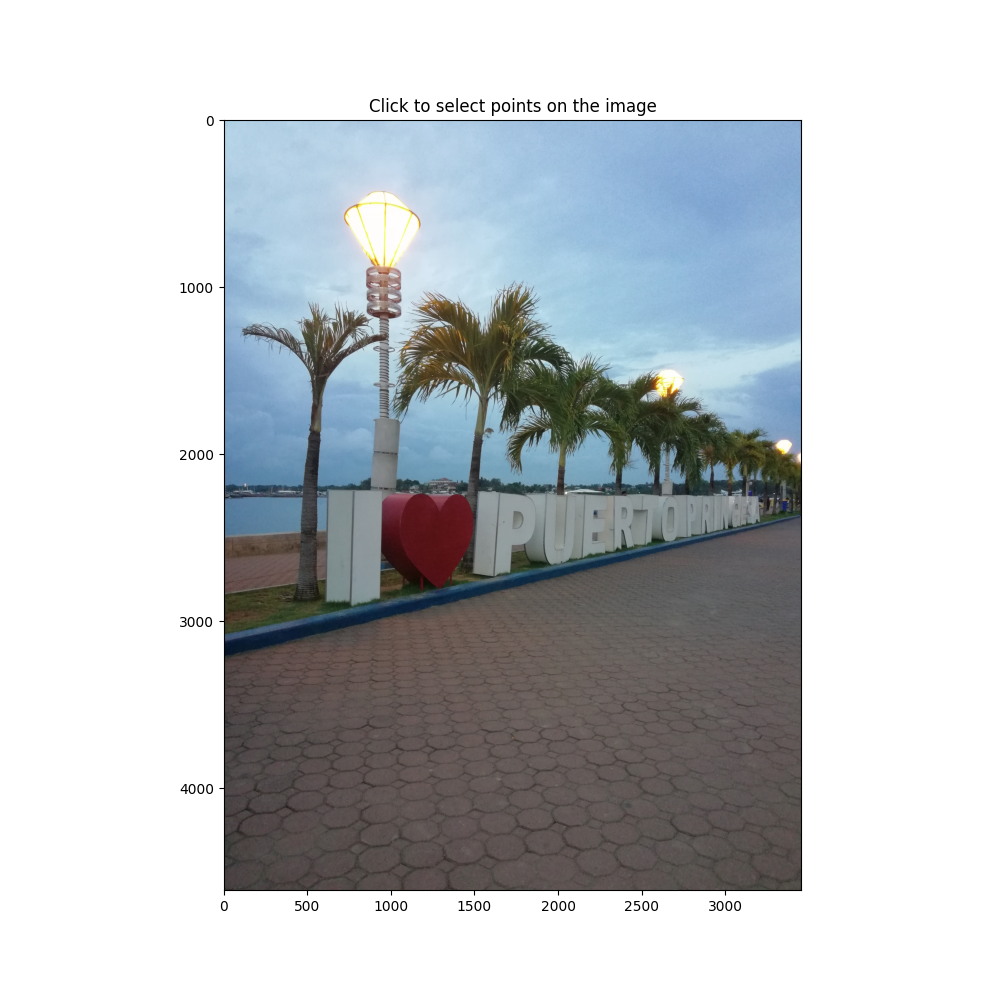


Selected Points: []
Point selected: (587.47, 2169.45)
Point selected: (617.39, 2957.00)
Point selected: (3208.64, 2394.46)
Point selected: (3190.69, 2190.99)


In [33]:
import matplotlib.pyplot as plt
import cv2


points = []


img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_rgb)
ax.set_title("Click to select points on the image")


def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        ix, iy = event.xdata, event.ydata
        points.append((ix, iy))
        print(f"Point selected: ({ix:.2f}, {iy:.2f})")


        ax.plot(ix, iy, 'ro')
        fig.canvas.draw()


cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

print("\nSelected Points:", points)

In [34]:
source_points=points

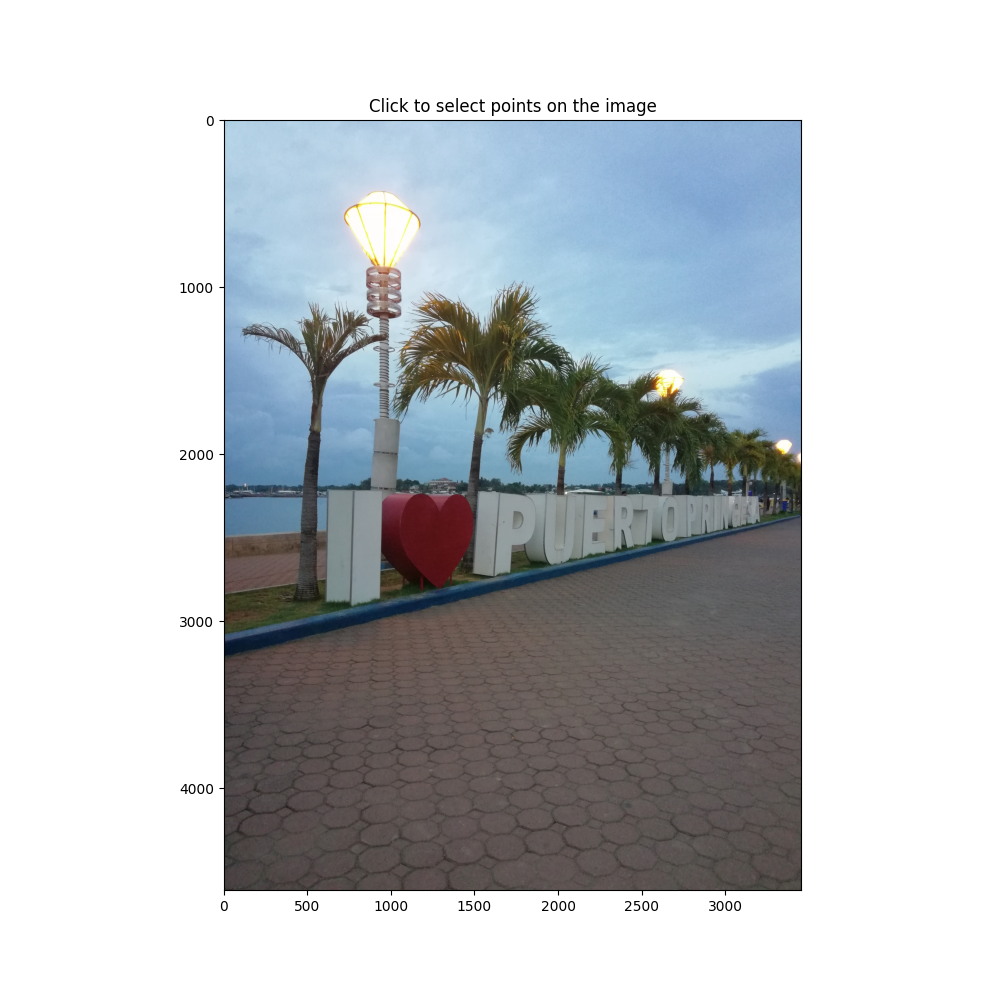


Selected Points: []
Point selected: (48.87, 1930.07)
Point selected: (36.90, 3208.34)
Point selected: (3430.07, 3214.33)
Point selected: (3406.13, 1772.08)


In [35]:
import matplotlib.pyplot as plt
import cv2


points = []


img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_rgb)
ax.set_title("Click to select points on the image")


def onclick(event):
    if event.xdata is not None and event.ydata is not None:  # Check if click is within the image
        ix, iy = event.xdata, event.ydata
        points.append((ix, iy))
        print(f"Point selected: ({ix:.2f}, {iy:.2f})")


        ax.plot(ix, iy, 'ro')  # Red dot
        fig.canvas.draw()


cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

print("\nSelected Points:", points)

In [36]:
destination_points=points

In [37]:

points_source = np.array([[x, y] for x, y in source_points])
points_target = np.array([[x, y] for x, y in destination_points])

In [38]:
print(points_source)
print(points_target)

[[ 587.46883117 2169.44908178]
 [ 617.39090909 2956.99818184]
 [3208.64285714 2394.4631169 ]
 [3190.68961039 2190.99298703]]
[[  48.87142857 1930.0724584 ]
 [  36.9025974  3208.34363638]
 [3430.06623377 3214.32805197]
 [3406.12857143 1772.08389612]]


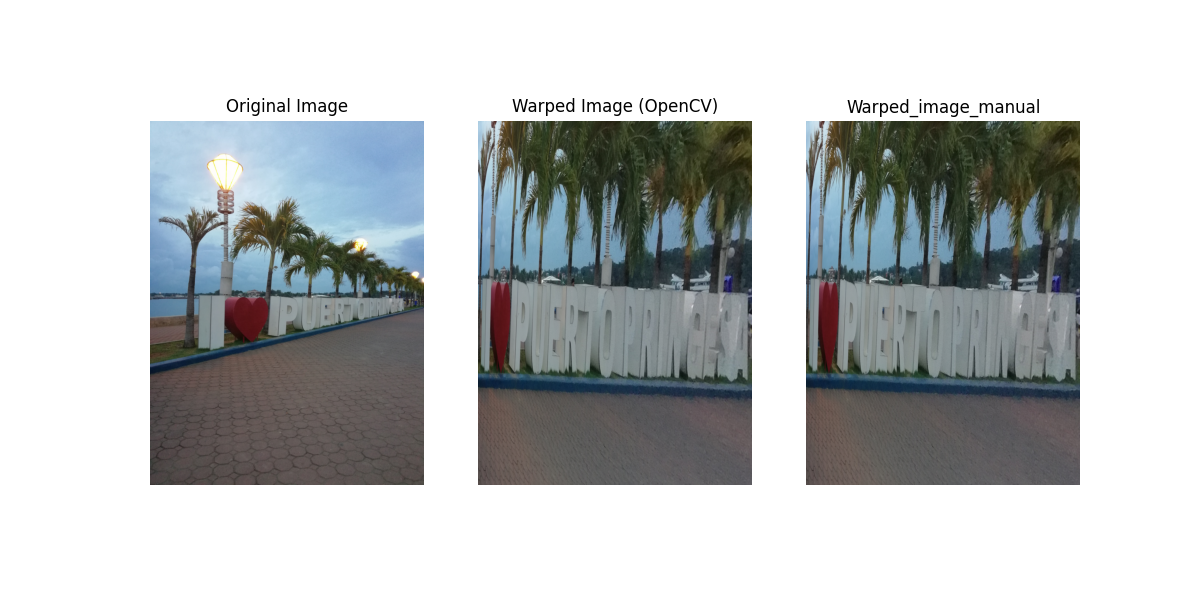

Computed Homography Matrix:
[[ 2.50571924e-01 -2.26964400e-02 -5.48916851e+01]
 [-5.26733959e-01  1.46949232e+00 -1.17748333e+03]
 [-2.60323829e-04  1.58013443e-05  1.00000000e+00]]


In [57]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


H = find_homography(points_source, points_target)

img = cv2.imread(image_path)


warped_image = cv2.warpPerspective(img, H, (img.shape[1], img.shape[0]))

warped_image_man = warpPerspective(img, H, (img.shape[1], img.shape[0]))


plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Warped Image (OpenCV)")
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Warped_image_manual")
plt.imshow(cv2.cvtColor(warped_image_man, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()




print("Computed Homography Matrix:")
print(H)



In [ ]:
cv2.imwrite('palawan_after homography.jpg', warped_image_man)

True